## 03 - Asset Value Over Time
Starting with the full record of my portfolio transactions, I aim to analyze how the `Market_Value` and Profit/Loss of my investments have evolved over time.

As a reminder, here how I calculate Profit/Loss:
| Incomes | Costs |
|---------------|------------------|
| (Current) Market_Value | Subscriptions |
| Redemptions | Commissions |
| Dividends | Taxes |

Ticker **Profit (Loss) = Incomes - Costs**

**Objective:**

In this notebook, I will track, for each portfolio TICKER, the following metrics over time:
- `Shares` held,
- `Subscriptions` (cumulative capital inflows allocated to purchase a ticker),
- `Redemptions` (cumulative capital outflows from the sale or liquidation of the asset),
- `Dividends` (cumulative cash dividends received for a ticker)
- `Costs`(Commissions + Taxes for transactional costs), 
- `Market_Value` (Shares held x Price),
- `Revenue` (Profit/Loss).

These will form the foundation for calculating portfolio performance metrics in the next chapter.

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
plt.style.use('ggplot')

In [3]:
# importing the function to load transactions from utils.py
from utils import load_transactions

I load my portfolio transactions:

In [4]:
excel_path = '../data/transactions_carlo.xlsx'
df_transacts = load_transactions(excel_path=excel_path, sheet_name=0)

#### A. Tracking TICKER Information Over Time
To calculate daily portfolio metrics, I need to collect the daily values of key parameters for each TICKER in my portfolio.

Starting from the `df_transacts` DataFrame, I can:
1. Identify the **start date** for each TICKER — i.e., the first day it appears in the portfolio.
2. Retrieve the TICKER's **daily price series** from its start date up to today.
3. Use the transaction records from `df_transacts` to:
    - Extract all transactions for the TICKER.
    - Align these with the price series DataFrame (via reindexing).
    - Compute the **daily number of shares held** for that TICKER.

This forms the basis for calculating time-series metrics such as market value, cost basis, and returns.

In [5]:
# 0. Define the ticker of interest
ticker = 'CSSPX'
# 1. Filter Transactions for the Ticker
mask= (df_transacts['Ticker'] == ticker)

# 2. Download Price Series from Yahoo Finance
prices = yf.download(tickers=ticker+'.MI', 
                     start = df_transacts[mask].index.min(),
                     end = pd.to_datetime("today").strftime("%Y-%m-%d"),
                     progress=False,
                     auto_adjust=False).loc[:,'Adj Close'] # 'auto_adjust = False' to work with 'Adj Close'

# 3. Calculate Daily Shares Held
shares= df_transacts[mask]['Shares'].reindex(prices.index, fill_value=0)
shares = shares.cumsum()

Now I create the `Subscrpitions`, `Redemptions`, and `Dividends` time series by coupling the `mask` to filter one Ticker's transactions to the `_mask` relative to the respective `Type` of transactions (`BUY`, `SELL`, `Dividend`):

In [6]:
# 4. Total Subscriptions (only 'BUY')
subs_mask = (df_transacts['Type'] == 'BUY')
subs = df_transacts[mask & subs_mask]['Amount'].reindex(prices.index, fill_value=0)
subs = subs.cumsum()
subs.name = 'Subscriptions'

# 5. Total Redemptions ('SELL' as positive inflows)
redemps_mask = (df_transacts['Type'] == 'SELL')
redemps = df_transacts[mask & redemps_mask]['Amount'].abs().reindex(prices.index, fill_value=0)
redemps = redemps.cumsum()
redemps.name = 'Redemptions'

# 6. Total Dividends
div_mask = (df_transacts['Type'] == 'Dividend')
div = df_transacts[mask & div_mask]['Amount'].abs().reindex(prices.index, fill_value=0)
div = div.cumsum()
div.name = 'Dividends'

Then I create the `Costs` time series by adding together `Commissions` and `Taxes` from each transaction (filtered for a single Ticker), summing the values row by row using `.sum(axis=1)`:

In [7]:
# 7. Total Costs (Commissions + Taxes)
costs = df_transacts[mask][['Commissions', 'Taxes']].sum(axis=1).reindex(prices.index, fill_value=0)
costs = costs.cumsum()
costs.name = 'Costs'

In [8]:
tick_timeseries = pd.concat([shares, prices, subs, redemps, div, costs], axis=1)
tick_timeseries.tail()

,Shares,CSSPX.MI,Subscriptions,Redemptions,Dividends,Costs
Date,,,,,,
2025-05-12,84,556.320007,38147.08,0.0,0.0,26.0
2025-05-13,84,561.520020,38147.08,0.0,0.0,26.0
2025-05-14,84,560.340027,38147.08,0.0,0.0,26.0
2025-05-15,84,561.750000,38147.08,0.0,0.0,26.0
2025-05-16,84,566.109985,38147.08,0.0,0.0,26.0


#### B. Writing a function to generate a TICKER time series.
I can wrap the above logic into a reusable function that tracks TICKER information over time, renaming as `[Price]` the column with the ticker's name `[CSSPX.MI]` and adding the columns `[Market_Value]` and `[Revenue]` to the time series DataFrame. The returned DataFrame is named from the ticker's name (e.g. CSSPX).

In [9]:
def get_ticker_timeseries(transactions: pd.DataFrame, ticker: str, market_suffix:str = '.MI') -> pd.DataFrame:
    """
    Returns a time series DataFrame tracking Shares Held, Prices, Subscriptions, Redemptions,
    Dividends, and Costs over time for a given Ticker, based on a transactions DataFrame.
    
    Parameters:
        transactions (pd.DataFrame): The full portfolio transactions DataFrame.
        ticker (str): The ticker symbol to track (without suffix like '.MI').
        market_suffix (str) : Suffix to append to ticker for market identification: '.MI' (default) 
        for Borsa Italiana
    
    Returns:
        pd.DataFrame: A time-indexed DataFrame with columns:
                      ['Shares', 'Price', 'Subscriptions', 'Redemptions', 'Dividends', 'Costs', 
                      'Market_Value', 'Revenue']
    """
    # 1. Filter Transactions for the Ticker
    mask = (transactions['Ticker'] == ticker)

    # 2. Download Price Series from Yahoo Finance
    prices = yf.download(
        tickers=ticker + market_suffix,
        start=transactions[mask].index.min(),
        end=pd.to_datetime("today").strftime("%Y-%m-%d"),
        progress=False,
        auto_adjust=False
    ).loc[:, 'Adj Close']

    prices.name = 'Adj Close'

    # 3. Daily Shares Held
    shares = transactions[mask]['Shares'].reindex(prices.index, fill_value=0).cumsum()
    shares.name = 'Shares'

    # 4. Subscriptions (BUY)
    subs = (
        transactions[mask & (transactions['Type'] == 'BUY')]['Amount']
        .reindex(prices.index, fill_value=0)
        .cumsum()
    )
    subs.name = 'Subscriptions'

    # 5. Redemptions (SELL)
    redemps = (
        transactions[mask & (transactions['Type'] == 'SELL')]['Amount']
        .abs().reindex(prices.index, fill_value=0)
        .cumsum()
    )
    redemps.name = 'Redemptions'

    # 6. Dividends
    div = (
        transactions[mask & (transactions['Type'] == 'Dividend')]['Amount']
        .abs().reindex(prices.index, fill_value=0)
        .cumsum()
    )
    div.name = 'Dividends'

    # 7. Costs (Commissions + Taxes)
    costs = (
        transactions[mask][['Commissions', 'Taxes']]
        .sum(axis=1)
        .reindex(prices.index, fill_value=0)
        .cumsum()
    )
    costs.name = 'Costs'

    # Combine all series into one DataFrame
    tick_timeseries = pd.concat([shares, prices, subs, redemps, div, costs], axis=1)
    
    tick_timeseries.rename(columns={ticker + market_suffix:'Price'}, inplace=True)
    
    # Name the DataFrame with the ticker
    tick_timeseries.name = ticker
    
    # Add 'Market_Value' and 'Revenue' columns
    tick_timeseries['Market_Value'] = tick_timeseries.Shares * tick_timeseries.Price
    
    tick_timeseries['Revenue'] = tick_timeseries[['Market_Value','Redemptions','Dividends']].sum(axis=1) -\
        tick_timeseries[['Subscriptions','Costs']].sum(axis=1)

    return tick_timeseries

In [10]:
# Example usage
csspx = get_ticker_timeseries(transactions=df_transacts, ticker='CSSPX')
csspx.tail()

,Shares,Price,Subscriptions,Redemptions,Dividends,Costs,Market_Value,Revenue
Date,,,,,,,,
2025-05-12,84,556.320007,38147.08,0.0,0.0,26.0,46730.880615,8557.800615
2025-05-13,84,561.520020,38147.08,0.0,0.0,26.0,47167.681641,8994.601641
2025-05-14,84,560.340027,38147.08,0.0,0.0,26.0,47068.562256,8895.482256
2025-05-15,84,561.750000,38147.08,0.0,0.0,26.0,47187.000000,9013.920000
2025-05-16,84,566.109985,38147.08,0.0,0.0,26.0,47553.238770,9380.158770


I labeled **Profit/Loss** as `Revenue` in this DataFrame. I can check that for each row of this DataFrame is `True` that:

`Revenue` = (`Market_Value` + `Redemptions` + `Dividends`) - (`Subscriptions` + `Costs`)

In [11]:
# check row by row equality by summing all True, and check that equals the lenght of the DataFrame
np.sum((csspx[['Market_Value','Redemptions','Dividends']].sum(axis=1)-
       csspx[['Subscriptions','Costs']].sum(axis=1)) == csspx['Revenue']) == len(csspx)

True

In [12]:
# check row by row equality using np.allclose()
np.allclose((csspx[['Market_Value','Redemptions','Dividends']].sum(axis=1)-
       csspx[['Subscriptions','Costs']].sum(axis=1)),csspx['Revenue'])

True

#### C. Evaluating the asset (Ticker) performance over time.

If I BUY a fixed number of shares of an asset and maintain that fixed number of shares for a certain period of time, I can calculate the asset total return as:
$$\text{Asset Total Return} = \frac{\text{Asset Price }_{\text{end}}}{\text{Asset Price }_{\text{start}}} - 1$$
But because I BUY and SELL Shares of my asset over time and I may occasionally receive some cash Dividends, I cannot just use the `Market_Value` of the asset over time to evaluate its performance. I need to consider that the asset Market_Value in my Portfolio may change over time after `Subscriptions` and `Redemptions`, not only after `Price` changes. 

So I need to find a *proxy* of the asset Price that takes into accounts all cash movements in or out the asset, and use this *proxy* to assess the asset performance. I want to compare the asset's `Market_Value` and/or `Income` to something that tells me if I'm earning or loosing money.
I can revisit the table that separates **incomes** and **costs** in my **asset**:
| Incomes | Costs |
|---------------|------------------|
| (Current) Market_Value | Subscriptions |
| Redemptions | Commissions |
| Dividends | Taxes |

*Notes:*
- In the code I define `Costs` as the sum of **Commissions** + **Taxes** (i.e., transactional costs).
- `Income` is defined as: `Market_Value` + `Redemptions` + `Dividends`.

I analyze my **asset costs** over time in two ways:
- `Tot_Costs` = `Subscriptions` + `Costs` → the **cumulative** amount of capital invested in the asset at each point in time.
- `Net_Costs` = (`Subscriptions` + `Costs`) - (`Redemptions` + `Dividends`) → the **net capital** still invested over time.

These serve as the denominators to normalize my asset's value over time, providing a clearer picture of its performance: 

$\text{Total Return Index} = \frac{\text{Income}}{\text{Total Costs}}$ → represents **Total Return** over time.

$\text{Active Investment Return Index} = \frac{\text{Market Value}}{\text{Net Costs}}$ → represents **Unrealized Return** on currently invested capital.

Finally, I define: **Profit/Loss = Income - Tot_Costs** = `Revenue`. Thus, the most recent value in the `Revenue` time series reflects the current profit or loss position of the asset.

<Axes: title={'center': 'CSSPX Total Return Index Over Time'}, xlabel='Date', ylabel='TRI Value'>

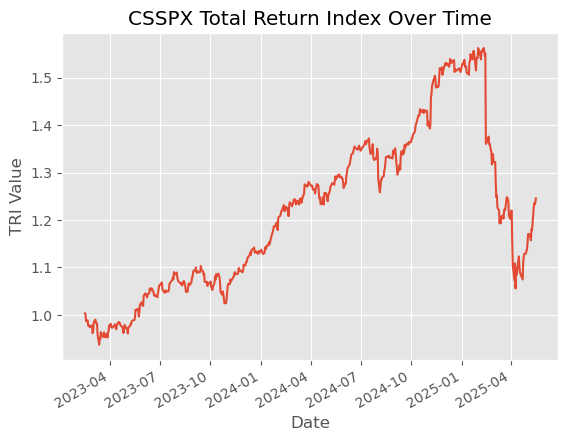

In [13]:
# Calculate Income and Tot_Costs and show the asset Total Return Index over time
csspx['Income'] = csspx[['Market_Value','Redemptions','Dividends']].sum(axis=1)
csspx['Tot_Costs'] = csspx[['Subscriptions','Costs']].sum(axis=1)
(csspx.Income/csspx.Tot_Costs).plot(title=csspx.name + ' Total Return Index Over Time',
                                          ylabel='TRI Value')

<Axes: title={'center': 'CSSPX Active Investment Return Index Over Time'}, xlabel='Date', ylabel='AIRI Value'>

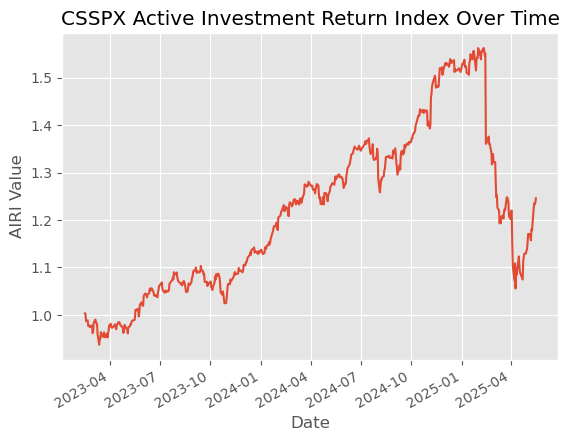

In [14]:
# Calculate Net_Costs and show the asset Active Investment Return Index over time
csspx['Net_Costs'] = csspx[['Subscriptions','Costs']].sum(axis=1) - csspx[['Redemptions','Dividends']].sum(axis=1)
(csspx.Market_Value/csspx.Net_Costs).plot(title=csspx.name + ' Active Investment Return Index Over Time',
                                          ylabel='AIRI Value')

In [15]:
csspx.head()

,Shares,Price,Subscriptions,Redemptions,Dividends,Costs,Market_Value,Revenue,Income,Tot_Costs,Net_Costs
Date,,,,,,,,,,,
2023-02-15,63,400.619995,25144.72,0.0,0.0,8.0,25239.059692,86.339692,25239.059692,25152.72,25152.72
2023-02-16,63,399.920013,25144.72,0.0,0.0,8.0,25194.960846,42.240846,25194.960846,25152.72,25152.72
2023-02-17,63,393.989990,25144.72,0.0,0.0,8.0,24821.369385,-331.350615,24821.369385,25152.72,25152.72
2023-02-20,63,394.660004,25144.72,0.0,0.0,8.0,24863.580231,-289.139769,24863.580231,25152.72,25152.72
2023-02-21,63,389.980011,25144.72,0.0,0.0,8.0,24568.740692,-583.979308,24568.740692,25152.72,25152.72


I can finally visualize the Time Series of the asset `Market_Value` and `Net_Costs`:

<Axes: title={'center': 'CSSPX Market Value and Net Costs Over Time'}, xlabel='Date', ylabel='Value (EUR)'>

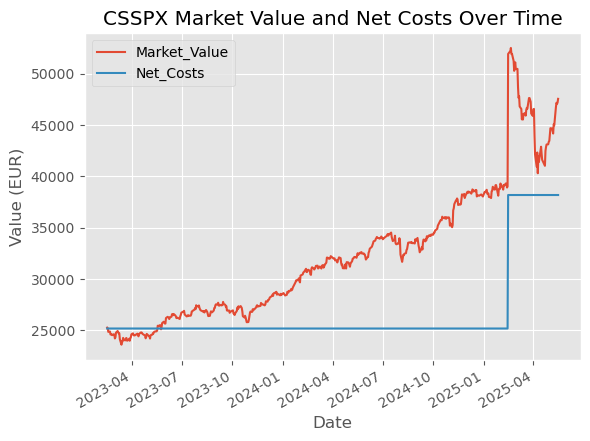

In [16]:
csspx[['Market_Value','Net_Costs']].plot(title = csspx.name + ' Market Value and Net Costs Over Time',
                                         ylabel = 'Value (EUR)')

#### D. Revising the function `get_ticker_timeseries()`.
I have just seen that to evaluate an asset performance I can use two indicators:
- the **Total Return Index (TRI)**
- the **Active Investment Return Index (AIRI)**

I will have the same need when putting together all the time series of the assets in my Portfolio to evaluate the Porfolio performance.

So, instead of deriving `Market_Value` and `Net_Costs` or `Income` and `Tot_Costs` per each asset as done in the above section, I can update my function to directly return these values, instead of their single components.

The first 7 steps of the function remain the same, but I will change the way I combine the series in the returned DataFrame, so that its columns are `[Shares, Price, Net_Costs, Tot_Costs, Income, Market_Value, Revenue]`

In [17]:
def get_ticker_timeseries(transactions: pd.DataFrame, ticker: str, market_suffix:str = '.MI') -> pd.DataFrame:
    """
    Returns a time series DataFrame tracking Shares Held, 'Price','Net_Costs','Tot_Cost','Income',
    'Market_Value' and'Revenue' over time for a given Ticker, based on a transactions DataFrame.
    
    Parameters:
        transactions (pd.DataFrame): The full portfolio transactions DataFrame.
        ticker (str): The ticker symbol to track (without suffix like '.MI').
        market_suffix (str) : Suffix to append to ticker for market identification: '.MI' (default) 
        for Borsa Italiana
    
    Returns:
        pd.DataFrame: A time-indexed DataFrame with columns:
                      [Shares','Price','Net_Costs','Tot_Cost','Income','Market_Value','Revenue']
    """
    # 1. Filter Transactions for the Ticker
    mask = (transactions['Ticker'] == ticker)

    # 2. Download Price Series from Yahoo Finance
    prices = yf.download(
        tickers=ticker + market_suffix,
        start=transactions[mask].index.min(),
        end=pd.to_datetime("today").strftime("%Y-%m-%d"),
        progress=False,
        auto_adjust=False
    ).loc[:, 'Adj Close']

    prices.name = 'Adj Close'

    # 3. Daily Shares Held
    shares = transactions[mask]['Shares'].reindex(prices.index, fill_value=0).cumsum()
    shares.name = 'Shares'

    # 4. Subscriptions (BUY)
    subs = (
        transactions[mask & (transactions['Type'] == 'BUY')]['Amount']
        .reindex(prices.index, fill_value=0)
        .cumsum()
    )
    subs.name = 'Subscriptions'

    # 5. Redemptions (SELL)
    redemps = (
        transactions[mask & (transactions['Type'] == 'SELL')]['Amount']
        .abs().reindex(prices.index, fill_value=0)
        .cumsum()
    )
    redemps.name = 'Redemptions'

    # 6. Dividends
    div = (
        transactions[mask & (transactions['Type'] == 'Dividend')]['Amount']
        .abs().reindex(prices.index, fill_value=0)
        .cumsum()
    )
    div.name = 'Dividends'

    # 7. Costs (Commissions + Taxes)
    costs = (
        transactions[mask][['Commissions', 'Taxes']]
        .sum(axis=1)
        .reindex(prices.index, fill_value=0)
        .cumsum()
    )
    costs.name = 'Costs'

    # Combine all series into one DataFrame
    tick_timeseries = pd.concat([shares, prices, subs, redemps, div, costs], axis=1)
    
    tick_timeseries.rename(columns={ticker + market_suffix:'Price'}, inplace=True)
    
    # Add 'Market_Value' and 'Revenue' columns
    tick_timeseries['Market_Value'] = tick_timeseries.Shares * tick_timeseries.Price
    
    tick_timeseries['Revenue'] = tick_timeseries[['Market_Value','Redemptions','Dividends']].sum(axis=1) -\
        tick_timeseries[['Subscriptions','Costs']].sum(axis=1)
    
    # Add 'Net_Costs', 'Tot_Cost', and 'Income' columns
    tick_timeseries['Net_Costs'] = tick_timeseries[['Subscriptions','Costs']].sum(axis=1) -\
        tick_timeseries[['Redemptions','Dividends']].sum(axis=1)
    
    tick_timeseries['Tot_Costs'] = tick_timeseries[['Subscriptions','Costs']].sum(axis=1)
    
    tick_timeseries['Income'] = tick_timeseries[['Market_Value','Redemptions','Dividends']].sum(axis=1) 
    
    # Drop unecessary columns
    tick_timeseries.drop(labels=['Subscriptions', 'Redemptions', 'Dividends', 'Costs'], axis=1, inplace=True)
    
    # re-order columns
    cols = ['Shares','Price','Net_Costs','Tot_Costs','Income','Market_Value','Revenue']
    tick_timeseries = tick_timeseries[cols]
    
    # Name the DataFrame with the ticker
    tick_timeseries.name = ticker

    return tick_timeseries

In [18]:
# Example usage
csspx = get_ticker_timeseries(transactions=df_transacts, ticker='CSSPX')
csspx.tail()

,Shares,Price,Net_Costs,Tot_Costs,Income,Market_Value,Revenue
Date,,,,,,,
2025-05-12,84,556.320007,38173.08,38173.08,46730.880615,46730.880615,8557.800615
2025-05-13,84,561.520020,38173.08,38173.08,47167.681641,47167.681641,8994.601641
2025-05-14,84,560.340027,38173.08,38173.08,47068.562256,47068.562256,8895.482256
2025-05-15,84,561.750000,38173.08,38173.08,47187.000000,47187.000000,9013.920000
2025-05-16,84,566.109985,38173.08,38173.08,47553.238770,47553.238770,9380.158770


### Summary
In this chapter, I explored how to track Ticker Time Series. I created the function `get_ticker_timeseries()` returning a time series DataFrame tracking Shares Held, Prices, Subscriptions, Redemptions, Dividends, Costs, Market_Value, and Revenue over time for a given Ticker from a transaction DataFrame.

I also explored how to evaluate an asset performance over time using two *proxies* taking into account that the market value of an asset may change for `Subscriptions` and `Redemptions`, not only for `Price` variations:

1. $\text{Total Return Index} = \frac{\text{Income}}{\text{Total Costs}}$ (**Total Return** over time).

2. $\text{Active Investment Return Index} = \frac{\text{Market Value}}{\text{Net Costs}}$ (**Unrealized Return** on currently invested capital)

Finally I updated the function `get_ticker_timeseries()` to return data needed for Portfolio performance evaluation.